In [1]:
import os
os.chdir("..")
from epilearn.models.SpatialTemporal import STGCN, ColaGNN
from epilearn.data import UniversalDataset
from epilearn.utils import transforms
from epilearn.tasks.forecast import Forecast
import torch
import matplotlib.pyplot as plt
import numpy as np


## What your data looks like:

In [2]:
data = torch.load("example.pt")
data.keys()

dict_keys(['features', 'graph', 'dynamic_graph', 'targets', 'states'])

In [3]:
print(f"Node Features[time steps, nodes, channels]: {data['features'].shape}")
print(f"Static Graph[nodes, nodes]: {data['graph'].shape}")
print(f"Dynamic Graph[time steps, nodes, nodes]: {data['dynamic_graph'].shape}")
print(f"Prediction Target[time steps, nodes]: {data['targets'].shape}")
print(f"Nodes States[time steps, nodes]: {data['states'].shape}")

Node Features[time steps, nodes, channels]: torch.Size([539, 47, 4])
Static Graph[nodes, nodes]: (47, 47)
Dynamic Graph[time steps, nodes, nodes]: torch.Size([539, 47, 47])
Prediction Target[time steps, nodes]: torch.Size([539, 47])
Nodes States[time steps, nodes]: torch.Size([539, 47])


In [4]:
node_features = data['features']
static_graph = torch.Tensor(data['graph'])
dynamic_graph = data['dynamic_graph']
targets = data['targets']
node_status = data['states']

In this example, we also use the target time series as one of the channels.

In [5]:
(node_features[:,:, 0] != targets).sum()

tensor(0)

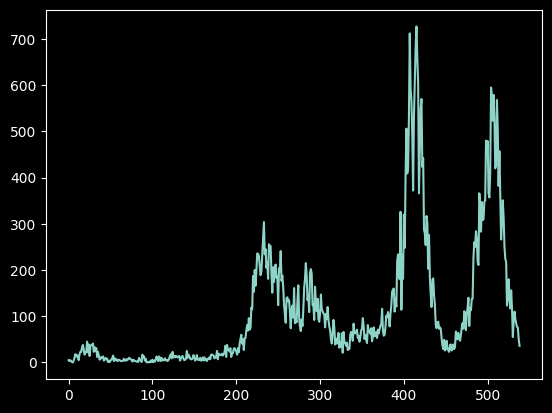

In [6]:
# first feature
plt.plot(np.array(node_features[:,0,0]))

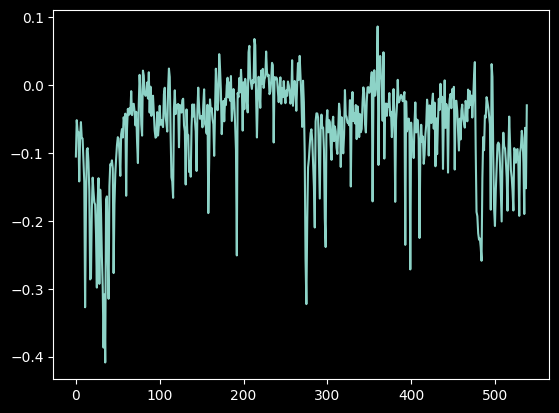

In [7]:
# second feature
plt.plot(np.array(node_features[:,0,1]))

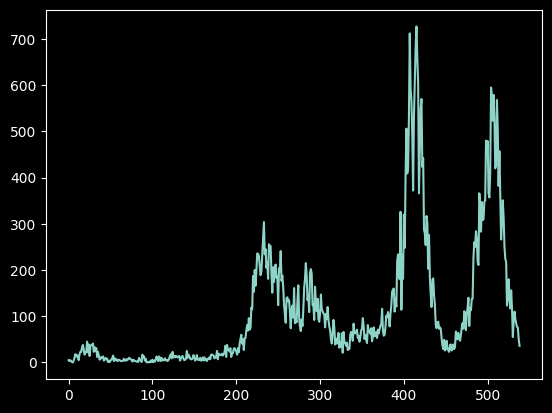

In [8]:
# prediction target
plt.plot(np.array(targets[:,0]))

## Loading your data into Epilearn dataset

Take spatial-temporal task as an example, we need ad least 1. node features; 2. target time series of every node; 3. graph (static or dynamic, depending on the model used)

In [9]:
dataset = UniversalDataset(x=node_features, 
                        #    states=node_status, # e.g. additional information of each node, e.g. SIR states
                           y=targets, # prediction target
                           graph=static_graph, # adjacency matrix, we also support edge index: edge_index = ...
                        #    dynamic_graph=dynamic_graph # # adjacency matrix
                           )

In [10]:
node_features.shape

torch.Size([539, 47, 4])

In [11]:
targets.shape

torch.Size([539, 47])

In [12]:
# initialize settings
lookback = 36 # inputs size
horizon = 3 # predicts size

# Adding Transformations
transformation = transforms.Compose({
                "features": [transforms.normalize_feat()],
                "target": [transforms.normalize_feat()],
                "graph": [transforms.normalize_adj()]})
dataset.transforms = transformation

# Initialize Task
task = Forecast(prototype=STGCN,
                dataset=None,
                lookback=lookback,
                horizon=horizon,
                device='cpu')
# model_args = {"num_features": 4, "num_timesteps_input": lookback, "num_timesteps_output":horizon, "num_nodes": 47}
# Training
result = task.train_model(dataset=dataset,
                          loss='mse',
                          epochs=2,
                          batch_size=5,
                          train_rate=0.6,
                          val_rate=0.2,
                          permute_dataset=True,
                        #   model_args=model_args
                          )

spatial-temporal model loaded!


100%|██████████| 2/2 [00:04<00:00,  2.17s/it]




Final Training loss: 0.11804907438917119
Final Validation loss: 0.8787687420845032
Test MSE: 4.754258632659912
Test MAE: 1.5053350925445557
Test RMSE: 2.1804263591766357


In [13]:
# Evaluation
train_evaluation = task.evaluate_model(model=task.model,
                                 features=task.train_split['features'],
                                 graph=task.adj, 
                                 dynamic_graph= task.train_split['dynamic_graph'], 
                                 states=task.train_split['states'], 
                                 targets=task.train_split['targets'])

Test MSE: 0.08834336698055267
Test MAE: 0.17457829415798187
Test RMSE: 0.2972261309623718


In [14]:
print(train_evaluation.keys())

dict_keys(['mse', 'mae', 'rmse', 'predictions', 'targets'])


In [15]:
print(train_evaluation['predictions'].shape)
print(train_evaluation['targets'].shape)

torch.Size([285, 47, 3])
torch.Size([285, 47, 3])


In [16]:
# when val_rate > 0
val_evaluation = task.evaluate_model(model=task.model,
                                 features=task.val_split['features'],
                                 graph=task.adj, 
                                 dynamic_graph= task.val_split['dynamic_graph'], 
                                 states=task.val_split['states'], 
                                 targets=task.val_split['targets'])

Test MSE: 0.8787687420845032
Test MAE: 0.6119647026062012
Test RMSE: 0.9374266862869263


In [17]:
test_evaluation = task.evaluate_model(model=task.model,
                                 features=task.test_split['features'],
                                 graph=task.adj, 
                                 dynamic_graph= task.test_split['dynamic_graph'], 
                                 states=task.test_split['states'], 
                                 targets=task.test_split['targets'])

Test MSE: 4.754258632659912
Test MAE: 1.5053350925445557
Test RMSE: 2.1804263591766357


### Temporal Task

As an example of temporal forecasting, we use a univariate time series as both feature and the target.

In [18]:
inputs = targets[:,0].unsqueeze(-1)
inputs.shape # length, channels

torch.Size([539, 1])

In [19]:
dataset = UniversalDataset(x=inputs, y=inputs)

In [20]:
from epilearn.models.Temporal import LSTMModel, DlinearModel, GRUModel
# initialize settings
lookback = 36 # inputs size
horizon = 3 # predicts size

# Adding Transformations
transformation = transforms.Compose({
                "features": [transforms.normalize_feat()],
                "target": [transforms.normalize_feat()]
                })
dataset.transforms = transformation

# Initialize Task
task = Forecast(prototype=DlinearModel,
                dataset=None,
                lookback=lookback,
                horizon=horizon,
                device='cpu')

# Training
result = task.train_model(dataset=dataset,
                          loss='mse',
                          epochs=40,
                          batch_size=8,
                          train_rate=0.6,
                          val_rate=0.1,
                          lr=1e-3,
                          permute_dataset=False)

temporal model loaded!


100%|██████████| 40/40 [00:00<00:00, 92.23it/s]



Final Training loss: 0.025770166668937437
Final Validation loss: 0.015421920455992222
Test MSE: 0.26374492049217224
Test MAE: 0.3796200454235077
Test RMSE: 0.5135610103607178


In [21]:
# for your customized model with unique parameters to initialize, please pass the parameters usinga a dict:
from epilearn.models.Temporal import LSTMModel, DlinearModel, GRUModel
# initialize settings
lookback = 36 # inputs size
horizon = 3 # predicts size

# Adding Transformations
transformation = transforms.Compose({
                "features": [transforms.normalize_feat()],
                "target": [transforms.normalize_feat()]
                })
dataset.transforms = transformation

# Initialize Task
task = Forecast(prototype=DlinearModel,
                dataset=None,
                lookback=lookback,
                horizon=horizon,
                device='cpu')


# hyperparameters of your model
model_args = {"num_features": 1, "num_timesteps_input": lookback, "num_timesteps_output":horizon}

# Training
result = task.train_model(dataset=dataset,
                          loss='mse',
                          epochs=40,
                          batch_size=8,
                          train_rate=0.6,
                          val_rate=0.1,
                          lr=1e-3,
                          permute_dataset=False,
                          model_args=model_args) # pass the hyperparameters of your model


100%|██████████| 40/40 [00:00<00:00, 94.66it/s]



Final Training loss: 0.02804178635900219
Final Validation loss: 0.015812238678336143
Test MSE: 0.3748167157173157
Test MAE: 0.4478873014450073
Test RMSE: 0.6122227907180786


Test MSE: 0.03676768019795418
Test MAE: 0.12715540826320648
Test RMSE: 0.19174900650978088
dict_keys(['mse', 'mae', 'rmse', 'predictions', 'targets'])


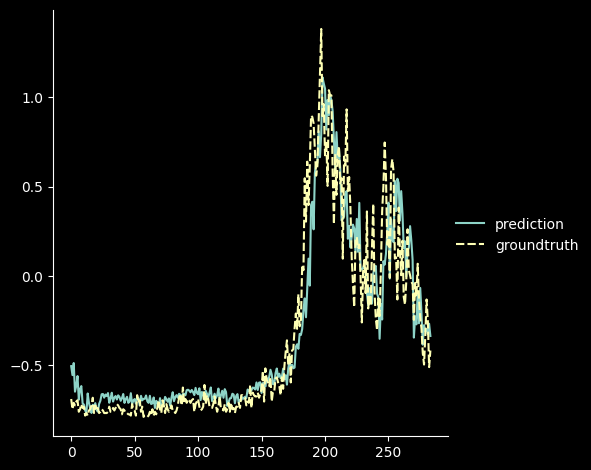

In [22]:
# Evaluation
train_evaluation = task.evaluate_model(model=task.model,
                                 features=task.train_split['features'],
                                 targets=task.train_split['targets'])
print(train_evaluation.keys())
train_results = task.plot_forecasts(dataset=task.train_dataset, index_range=[0,-1])

Test MSE: 0.3748167157173157
Test MAE: 0.4478873014450073
Test RMSE: 0.6122227907180786


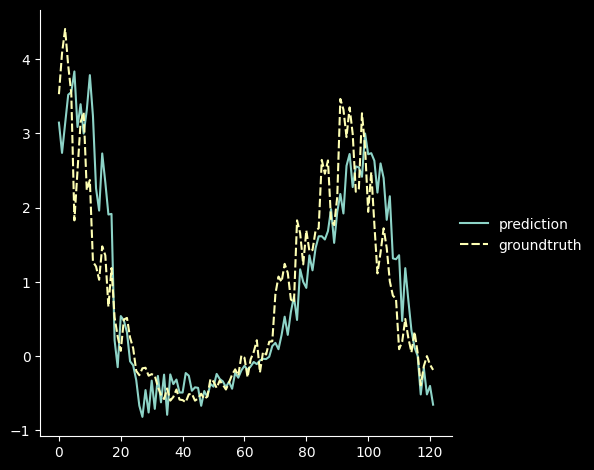

In [23]:
# Evaluation
evaluation = task.evaluate_model(model=task.model,
                                 features=task.test_split['features'],
                                 targets=task.test_split['targets'])
val_results = task.plot_forecasts(dataset=task.test_dataset, index_range=[0,-1])     

## Spatial Task

As an example of Spatial detection, we need 1. static graph; 2. node features 3. target of each node

### Spatial-Temporal data as input

In [24]:
graph = static_graph # nodes, nodes
features = torch.round(torch.rand((10,47,16,4))) # batch, nodes, time steps, channels
node_target = torch.round(torch.rand((10,47))) # batch, nodes
print(f"graph: {graph.shape}")
print(f"features: {features.shape}")
print(f"node_target: {node_target.shape}")

graph: torch.Size([47, 47])
features: torch.Size([10, 47, 16, 4])
node_target: torch.Size([10, 47])


Assuming we have binary class labels, and we want to do binary classification on each node

In [25]:
node_target

tensor([[0., 0., 1., 0., 1., 0., 0., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 0.,
         1., 0., 0., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0., 1.,
         1., 1., 0., 0., 0., 1., 0., 0., 1., 0., 1.],
        [0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0.,
         1., 0., 1., 1., 1., 1., 0., 0., 1., 0., 0., 1., 1., 1., 1., 1., 0., 1.,
         1., 0., 0., 0., 0., 1., 1., 0., 0., 0., 0.],
        [1., 0., 1., 1., 0., 0., 0., 1., 0., 1., 0., 1., 1., 1., 0., 0., 1., 1.,
         1., 0., 1., 1., 0., 0., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0., 1., 1.,
         1., 1., 1., 1., 1., 0., 0., 0., 0., 1., 0.],
        [0., 1., 1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 1., 0., 0., 0., 1., 1.,
         1., 0., 0., 1., 1., 1., 1., 1., 0., 0., 1., 0., 0., 0., 0., 1., 1., 0.,
         0., 1., 0., 0., 1., 0., 1., 0., 1., 0., 0.],
        [1., 0., 0., 1., 1., 1., 0., 1., 1., 0., 0., 0., 0., 1., 1., 1., 1., 0.,
         0., 1., 1., 0., 1., 0., 0., 1., 0., 0., 0., 1.

In [26]:
print(f"node_target: {node_target.shape}")

node_target: torch.Size([10, 47])


In [27]:
dataset = UniversalDataset(x=features,y=node_target,graph=graph)

In [28]:
from epilearn.tasks.detection import Detection
from epilearn.models.SpatialTemporal import STGCN

lookback = 16 # inputs size
horizon = 2 # predicts size; also seen as number of classes, here we have two classes: 0, 1

dataset.transforms = None
task = Detection(prototype=STGCN, dataset=dataset, lookback=lookback, horizon=horizon, device='cpu')

result = task.train_model(dataset=dataset, 
                          loss='ce', 
                          epochs=25,
                          train_rate=0.6,
                          val_rate=0.1,
                          permute_dataset=True,
                          )

spatial-temporal model loaded!


100%|██████████| 25/25 [00:00<00:00, 60.63it/s]



Final Training loss: 0.10349763929843903
Final Validation loss: 1.4674010276794434
Test ACC: 0.41843971610069275


In [29]:
# Train Evaluation
train_evaluation = task.evaluate_model(model=task.model,
                                 features=task.train_split['features'],
                                 graph=task.adj, 
                                 dynamic_graph= task.train_split['dynamic_graph'], 
                                 states=task.train_split['states'], 
                                 targets=task.train_split['targets'])

train_evaluation.keys()

ACC: 0.6595744490623474


dict_keys(['acc', 'predictions', 'targets'])

In [30]:
# Val Evaluation
val_evaluation = task.evaluate_model(model=task.model,
                                 features=task.val_split['features'],
                                 graph=task.adj, 
                                 dynamic_graph= task.val_split['dynamic_graph'], 
                                 states=task.val_split['states'], 
                                 targets=task.val_split['targets'])

ACC: 0.4680851101875305


In [31]:
# Val Evaluation
test_evaluation = task.evaluate_model(model=task.model,
                                 features=task.test_split['features'],
                                 graph=task.adj, 
                                 dynamic_graph= task.test_split['dynamic_graph'], 
                                 states=task.test_split['states'], 
                                 targets=task.test_split['targets'])

ACC: 0.41843971610069275


### Spatial data as input

In [32]:
graph = static_graph # nodes, nodes
features = torch.round(torch.rand((10,47,1,4))) # batch, nodes, time steps=1, channels
node_target = torch.round(torch.rand((10,47))) # batch, nodes
print(f"graph: {graph.shape}")
print(f"features: {features.shape}")
print(f"node_target: {node_target.shape}")

graph: torch.Size([47, 47])
features: torch.Size([10, 47, 1, 4])
node_target: torch.Size([10, 47])


In [33]:
dataset = UniversalDataset(x=features,y=node_target,graph=graph)

In [34]:
from epilearn.tasks.detection import Detection
from epilearn.models.Spatial.GCN import GCN

lookback = 1 # inputs size
horizon = 2 # predicts size; also seen as number of classes

dataset.transforms = None
task = Detection(prototype=GCN, dataset=dataset, lookback=lookback, horizon=horizon, device='cpu')

# model_args={"num_features": 4, "hidden_dim": 16, "num_classes": 2, "nlayers": 2, "dropout": 0.5,
#             "with_bn": False, "with_bias": True, "device": 'cpu'}

result = task.train_model(dataset=dataset, 
                          loss='ce', 
                          epochs=25,
                          train_rate=0.6,
                          val_rate=0.1,
                          permute_dataset=False,
                        #   model_args=model_args
                          )

spatial model loaded!


100%|██████████| 25/25 [00:00<00:00, 181.84it/s]



Final Training loss: 0.6961597204208374
Final Validation loss: 0.6982224583625793

Predicting Progress...


100%|██████████| 3/3 [00:00<00:00, 645.97it/s]

Test ACC: 0.4609929025173187


In [35]:
# Train Evaluation
train_evaluation = task.evaluate_model(model=task.model,
                                 features=task.train_split['features'],
                                 graph=task.adj, 
                                 dynamic_graph= task.train_split['dynamic_graph'], 
                                 states=task.train_split['states'], 
                                 targets=task.train_split['targets'])

train_evaluation.keys()


Predicting Progress...


100%|██████████| 6/6 [00:00<00:00, 798.51it/s]

ACC: 0.521276593208313


dict_keys(['acc', 'predictions', 'targets'])